# 🚀 Advanced Feature Engineering
## Combinazione di tutti i dataset disponibili per massimizzare le performance

### Obiettivo:
Predire il **net_weight** delle ricezioni future per minimizzare il **quantile loss (q=0.8)**

### Dataset utilizzati:
1. ✅ **receivals.csv** (obbligatorio) - dati storici delle ricezioni
2. ✅ **purchase_orders.csv** - ordini di acquisto con quantità previste
3. ✅ **materials.csv** - informazioni sui materiali
4. ✅ **transportation.csv** - dettagli sulla logistica e trasporto

### Strategia:
- Unire i dataset tramite chiavi comuni (rm_id, product_id, purchase_order_id)
- Creare feature avanzate che catturano pattern temporali, relazioni tra entità, e anomalie
- Feature engineering ottimizzato per quantile regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configurazione visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("📦 Librerie caricate con successo!")

📦 Librerie caricate con successo!


## 1. Caricamento dei Dataset

In [2]:
# Percorsi dei dataset
DATA_PATH = '../../data/'

# Caricamento dataset principali
print("📊 Caricamento dataset...")
receivals = pd.read_csv(DATA_PATH + 'kernel/receivals.csv')
purchase_orders = pd.read_csv(DATA_PATH + 'kernel/purchase_orders.csv')
materials = pd.read_csv(DATA_PATH + 'extended/materials.csv')
transportation = pd.read_csv(DATA_PATH + 'extended/transportation.csv')
prediction_mapping = pd.read_csv(DATA_PATH + 'prediction_mapping.csv')

print(f"\n✅ Dataset caricati:")
print(f"   Receivals: {receivals.shape}")
print(f"   Purchase Orders: {purchase_orders.shape}")
print(f"   Materials: {materials.shape}")
print(f"   Transportation: {transportation.shape}")
print(f"   Prediction Mapping: {prediction_mapping.shape}")

# Quick look
print("\n📋 Prime righe di Receivals:")
display(receivals.head())

print("\n📋 Prime righe di Purchase Orders:")
display(purchase_orders.head())

📊 Caricamento dataset...

✅ Dataset caricati:
   Receivals: (122590, 10)
   Purchase Orders: (33171, 12)
   Materials: (1218, 6)
   Transportation: (122590, 23)
   Prediction Mapping: (30450, 4)

📋 Prime righe di Receivals:

✅ Dataset caricati:
   Receivals: (122590, 10)
   Purchase Orders: (33171, 12)
   Materials: (1218, 6)
   Transportation: (122590, 23)
   Prediction Mapping: (30450, 4)

📋 Prime righe di Receivals:


,rm_id,product_id,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,date_arrival,receival_status,net_weight,supplier_id
0,365.0,91900143.0,208545.0,10.0,1,NaN,2004-06-15 13:34:00 +02:00,Completed,11420.0,52062
1,365.0,91900143.0,208545.0,10.0,2,NaN,2004-06-15 13:34:00 +02:00,Completed,13760.0,52062
2,365.0,91900143.0,208490.0,10.0,1,NaN,2004-06-15 13:38:00 +02:00,Completed,11281.0,50468
3,365.0,91900143.0,208490.0,10.0,2,NaN,2004-06-15 13:38:00 +02:00,Completed,13083.0,50468
4,379.0,91900296.0,210435.0,20.0,1,NaN,2004-06-15 13:40:00 +02:00,Completed,23910.0,52577



📋 Prime righe di Purchase Orders:


,purchase_order_id,purchase_order_item_no,quantity,delivery_date,product_id,product_version,created_date_time,modified_date_time,unit_id,unit,status_id,status
0,1,1,-14.0,2003-05-12 00:00:00.0000000 +02:00,91900143,1,2003-05-12 10:00:48.0000000 +00:00,2004-06-15 06:16:18.0000000 +00:00,NaN,NaN,2,Closed
1,22,1,23880.0,2003-05-27 00:00:00.0000000 +02:00,91900160,1,2003-05-27 12:42:07.0000000 +00:00,2012-06-29 09:41:13.0000000 +00:00,NaN,NaN,2,Closed
2,41,1,0.0,2004-03-08 00:00:00.0000000 +01:00,91900143,1,2004-03-08 13:44:31.0000000 +00:00,2012-07-04 13:51:02.0000000 +00:00,NaN,NaN,2,Closed
3,61,1,0.0,2004-03-10 00:00:00.0000000 +01:00,91900143,1,2004-03-10 11:39:06.0000000 +00:00,2012-07-04 13:50:59.0000000 +00:00,NaN,NaN,2,Closed
4,141,10,25000.0,2004-10-28 00:00:00.0000000 +02:00,91900143,1,2004-10-22 12:21:54.0000000 +00:00,2012-07-04 13:50:55.0000000 +00:00,NaN,NaN,2,Closed


## 2. Data Cleaning e Preparazione

In [3]:
# Converti date columns
print("🔧 Conversione colonne temporali...")

# Receivals
receivals['date_arrival'] = pd.to_datetime(receivals['date_arrival'])

# Purchase Orders
purchase_orders['delivery_date'] = pd.to_datetime(purchase_orders['delivery_date'])
purchase_orders['created_date_time'] = pd.to_datetime(purchase_orders['created_date_time'])
purchase_orders['modified_date_time'] = pd.to_datetime(purchase_orders['modified_date_time'])

# Prediction mapping
prediction_mapping['forecast_start_date'] = pd.to_datetime(prediction_mapping['forecast_start_date'])
prediction_mapping['forecast_end_date'] = pd.to_datetime(prediction_mapping['forecast_end_date'])

print("\n✅ Date convertite!")
print(f"\n📅 Range temporale Receivals:")
print(f"   Min: {receivals['date_arrival'].min()}")
print(f"   Max: {receivals['date_arrival'].max()}")
print(f"   Span: {(receivals['date_arrival'].max() - receivals['date_arrival'].min()).days} giorni")

# Rimuovi righe con net_weight mancante o negativo
print(f"\n🔍 Pulizia dati...")
print(f"   Righe originali: {len(receivals)}")
receivals = receivals[receivals['net_weight'].notna()]
receivals = receivals[receivals['net_weight'] > 0]
print(f"   Righe dopo pulizia: {len(receivals)}")
print(f"   Righe rimosse: {122592 - len(receivals)}")

🔧 Conversione colonne temporali...

✅ Date convertite!

📅 Range temporale Receivals:
   Min: 2004-06-15 13:34:00+02:00
   Max: 2024-12-19 13:36:00+00:00
   Span: 7492 giorni

🔍 Pulizia dati...
   Righe originali: 122590
   Righe dopo pulizia: 122385
   Righe rimosse: 207

✅ Date convertite!

📅 Range temporale Receivals:
   Min: 2004-06-15 13:34:00+02:00
   Max: 2024-12-19 13:36:00+00:00
   Span: 7492 giorni

🔍 Pulizia dati...
   Righe originali: 122590
   Righe dopo pulizia: 122385
   Righe rimosse: 207


## 3. Merge con Purchase Orders
### Obiettivo: Estrarre informazioni sulla quantità ordinata

In [6]:
print("🔗 Merge Receivals + Purchase Orders...")

# Prepara purchase orders
po_features = purchase_orders[[
    'purchase_order_id', 'purchase_order_item_no', 'quantity', 
    'delivery_date', 'product_id', 'created_date_time', 'modified_date_time', 'status'
]].copy()

# Rinomina per evitare conflitti
po_features.rename(columns={
    'product_id': 'po_product_id',
    'quantity': 'ordered_quantity',
    'status': 'order_status'
}, inplace=True)

# Merge
data = receivals.merge(
    po_features,
    on=['purchase_order_id', 'purchase_order_item_no'],
    how='left'
)

print(f"\n✅ Merge completato: {data.shape}")
print(f"   Match rate: {(~data['ordered_quantity'].isna()).sum() / len(data) * 100:.2f}%")

# Calcola differenza tra quantità ordinata e peso ricevuto
data['order_vs_actual'] = data['ordered_quantity'] - data['net_weight']
data['order_fulfillment_ratio'] = (data['net_weight'] / data['ordered_quantity']).clip(0, 2)  # Cap outliers

# Tempo tra creazione ordine e ricezione
data['days_order_to_receival'] = (pd.to_datetime(data['date_arrival'], utc=True) - pd.to_datetime(data['created_date_time'], utc=True)).dt.days
data['days_delivery_to_receival'] = (pd.to_datetime(data['date_arrival'], utc=True) - pd.to_datetime(data['delivery_date'], utc=True)).dt.days

print("\n📊 Nuove feature da Purchase Orders:")
print("   - ordered_quantity")
print("   - order_vs_actual (differenza)")
print("   - order_fulfillment_ratio")
print("   - days_order_to_receival")
print("   - days_delivery_to_receival")

🔗 Merge Receivals + Purchase Orders...

✅ Merge completato: (122385, 16)
   Match rate: 100.00%

📊 Nuove feature da Purchase Orders:
   - ordered_quantity
   - order_vs_actual (differenza)
   - order_fulfillment_ratio
   - days_order_to_receival
   - days_delivery_to_receival

📊 Nuove feature da Purchase Orders:
   - ordered_quantity
   - order_vs_actual (differenza)
   - order_fulfillment_ratio
   - days_order_to_receival
   - days_delivery_to_receival


## 4. Merge con Materials
### Obiettivo: Informazioni su lega e formato del materiale

In [7]:
print("🔗 Merge con Materials...")

# Prepara materials (usa product_id come chiave principale)
materials_clean = materials[['rm_id', 'product_id', 'raw_material_alloy', 
                              'raw_material_format_type', 'stock_location']].copy()

# Rimuovi duplicati (prendi la versione più recente)
materials_clean = materials_clean.drop_duplicates(subset=['rm_id', 'product_id'], keep='last')

# Merge
data = data.merge(
    materials_clean,
    on=['rm_id', 'product_id'],
    how='left'
)

print(f"\n✅ Merge completato: {data.shape}")
print(f"   Match rate: {(~data['raw_material_alloy'].isna()).sum() / len(data) * 100:.2f}%")

# Encoding categoriali per alloy e format
data['alloy_encoded'] = pd.factorize(data['raw_material_alloy'].fillna('Unknown'))[0]
data['format_encoded'] = pd.factorize(data['raw_material_format_type'].fillna(0))[0]

print("\n📊 Nuove feature da Materials:")
print("   - raw_material_alloy")
print("   - raw_material_format_type")
print("   - alloy_encoded")
print("   - format_encoded")

🔗 Merge con Materials...

✅ Merge completato: (122385, 23)
   Match rate: 100.00%

📊 Nuove feature da Materials:
   - raw_material_alloy
   - raw_material_format_type
   - alloy_encoded
   - format_encoded


## 5. Merge con Transportation
### Obiettivo: Informazioni su trasporto, peso lordo, deduzioni

In [8]:
print("🔗 Merge con Transportation...")

# Prepara transportation features
transport_features = transportation[[
    'rm_id', 'product_id', 'purchase_order_id', 'purchase_order_item_no', 'receival_item_no',
    'transporter_name', 'gross_weight', 'tare_weight', 'wood', 'ironbands', 
    'plastic', 'water', 'ice', 'other', 'chips', 'packaging', 'cardboard'
]].copy()

# Merge usando tutte le chiavi disponibili
data = data.merge(
    transport_features,
    on=['rm_id', 'product_id', 'purchase_order_id', 'purchase_order_item_no', 'receival_item_no'],
    how='left'
)

print(f"\n✅ Merge completato: {data.shape}")
print(f"   Match rate: {(~data['gross_weight'].isna()).sum() / len(data) * 100:.2f}%")

# Feature engineering dal transportation
# 1. Totale deduzioni (impurità)
deduction_cols = ['wood', 'ironbands', 'plastic', 'water', 'ice', 'other', 'chips', 'packaging', 'cardboard']
data['total_deductions'] = data[deduction_cols].fillna(0).sum(axis=1)

# 2. Rapporti
data['net_to_gross_ratio'] = (data['net_weight'] / data['gross_weight']).fillna(1).clip(0, 1)
data['tare_to_gross_ratio'] = (data['tare_weight'] / data['gross_weight']).fillna(0).clip(0, 1)
data['deductions_to_gross_ratio'] = (data['total_deductions'] / data['gross_weight']).fillna(0).clip(0, 1)

# 3. Encoding transporter
data['transporter_encoded'] = pd.factorize(data['transporter_name'].fillna('Unknown'))[0]

print("\n📊 Nuove feature da Transportation:")
print("   - gross_weight, tare_weight")
print("   - total_deductions (wood, plastic, water, etc.)")
print("   - net_to_gross_ratio")
print("   - tare_to_gross_ratio")
print("   - deductions_to_gross_ratio")
print("   - transporter_encoded")

🔗 Merge con Transportation...

✅ Merge completato: (2189853, 37)
   Match rate: 100.00%

✅ Merge completato: (2189853, 37)
   Match rate: 100.00%

📊 Nuove feature da Transportation:
   - gross_weight, tare_weight
   - total_deductions (wood, plastic, water, etc.)
   - net_to_gross_ratio
   - tare_to_gross_ratio
   - deductions_to_gross_ratio
   - transporter_encoded

📊 Nuove feature da Transportation:
   - gross_weight, tare_weight
   - total_deductions (wood, plastic, water, etc.)
   - net_to_gross_ratio
   - tare_to_gross_ratio
   - deductions_to_gross_ratio
   - transporter_encoded


## 6. Feature Engineering Avanzato - Temporal Features

In [11]:
print("⏰ Creazione feature temporali avanzate...")

# Ordina per data
data = data.sort_values('date_arrival').reset_index(drop=True)

# 1. Componenti temporali base
data['year'] = pd.to_datetime(data['date_arrival'], format='%Y-%m-%d %H:%M:%S %z', utc=True).dt.year
data['month'] = pd.to_datetime(data['date_arrival'], format='%Y-%m-%d %H:%M:%S %z', utc=True).dt.month
data['day'] = pd.to_datetime(data['date_arrival'], format='%Y-%m-%d %H:%M:%S %z', utc=True).dt.day
data['day_of_week'] = pd.to_datetime(data['date_arrival'], format='%Y-%m-%d %H:%M:%S %z', utc=True).dt.dayofweek
data['quarter'] = pd.to_datetime(data['date_arrival'], format='%Y-%m-%d %H:%M:%S %z', utc=True).dt.quarter
data['week_of_year'] = pd.to_datetime(data['date_arrival'], format='%Y-%m-%d %H:%M:%S %z', utc=True).dt.isocalendar().week
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
data['is_month_start'] = pd.to_datetime(data['date_arrival'], format='%Y-%m-%d %H:%M:%S %z', utc=True).dt.is_month_start.astype(int)
data['is_month_end'] = pd.to_datetime(data['date_arrival'], format='%Y-%m-%d %H:%M:%S %z', utc=True).dt.is_month_end.astype(int)
data['is_quarter_start'] = pd.to_datetime(data['date_arrival'], format='%Y-%m-%d %H:%M:%S %z', utc=True).dt.is_quarter_start.astype(int)
data['is_quarter_end'] = pd.to_datetime(data['date_arrival'], format='%Y-%m-%d %H:%M:%S %z', utc=True).dt.is_quarter_end.astype(int)

# 2. Feature ciclici (per catturare periodicità)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
data['week_sin'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
data['week_cos'] = np.cos(2 * np.pi * data['week_of_year'] / 52)

# 3. Tempo dall'inizio
data['days_since_start'] = (pd.to_datetime(data['date_arrival'], format='%Y-%m-%d %H:%M:%S %z', utc=True) - pd.to_datetime(data['date_arrival'].min(), format='%Y-%m-%d %H:%M:%S %z', utc=True)).dt.days
data['weeks_since_start'] = data['days_since_start'] / 7

print("\n✅ Feature temporali create!")
print(f"   Componenti: year, month, day, day_of_week, quarter, week_of_year")
print(f"   Binarie: is_weekend, is_month_start/end, is_quarter_start/end")
print(f"   Cicliche: month_sin/cos, day_sin/cos, week_sin/cos")
print(f"   Tempo: days_since_start, weeks_since_start")

⏰ Creazione feature temporali avanzate...

✅ Feature temporali create!
   Componenti: year, month, day, day_of_week, quarter, week_of_year
   Binarie: is_weekend, is_month_start/end, is_quarter_start/end
   Cicliche: month_sin/cos, day_sin/cos, week_sin/cos
   Tempo: days_since_start, weeks_since_start

✅ Feature temporali create!
   Componenti: year, month, day, day_of_week, quarter, week_of_year
   Binarie: is_weekend, is_month_start/end, is_quarter_start/end
   Cicliche: month_sin/cos, day_sin/cos, week_sin/cos
   Tempo: days_since_start, weeks_since_start


## 7. Feature Engineering Avanzato - Aggregazioni per Entità

In [12]:
print("📊 Creazione aggregazioni per entità...")

# ========== SUPPLIER FEATURES ==========
print("\n👨‍🏭 Supplier features...")
supplier_agg = data.groupby('supplier_id')['net_weight'].agg([
    ('supplier_mean', 'mean'),
    ('supplier_median', 'median'),
    ('supplier_std', 'std'),
    ('supplier_min', 'min'),
    ('supplier_max', 'max'),
    ('supplier_q25', lambda x: x.quantile(0.25)),
    ('supplier_q75', lambda x: x.quantile(0.75)),
    ('supplier_count', 'count')
]).reset_index()

data = data.merge(supplier_agg, on='supplier_id', how='left')

# Coefficient of variation
data['supplier_cv'] = data['supplier_std'] / (data['supplier_mean'] + 1e-6)

# ========== RM_ID FEATURES ==========
print("🧱 Raw Material features...")
rm_agg = data.groupby('rm_id')['net_weight'].agg([
    ('rm_mean', 'mean'),
    ('rm_median', 'median'),
    ('rm_std', 'std'),
    ('rm_min', 'min'),
    ('rm_max', 'max'),
    ('rm_count', 'count')
]).reset_index()

data = data.merge(rm_agg, on='rm_id', how='left')
data['rm_cv'] = data['rm_std'] / (data['rm_mean'] + 1e-6)

# ========== PRODUCT FEATURES ==========
print("📦 Product features...")
product_agg = data.groupby('product_id')['net_weight'].agg([
    ('product_mean', 'mean'),
    ('product_median', 'median'),
    ('product_std', 'std'),
    ('product_count', 'count')
]).reset_index()

data = data.merge(product_agg, on='product_id', how='left')
data['product_cv'] = data['product_std'] / (data['product_mean'] + 1e-6)

# ========== TRANSPORTER FEATURES ==========
print("🚚 Transporter features...")
transporter_agg = data.groupby('transporter_name')['net_weight'].agg([
    ('transporter_mean', 'mean'),
    ('transporter_std', 'std'),
    ('transporter_count', 'count')
]).reset_index()

data = data.merge(transporter_agg, on='transporter_name', how='left')

print("\n✅ Aggregazioni completate!")

📊 Creazione aggregazioni per entità...

👨‍🏭 Supplier features...
🧱 Raw Material features...
🧱 Raw Material features...
📦 Product features...
📦 Product features...
🚚 Transporter features...
🚚 Transporter features...

✅ Aggregazioni completate!

✅ Aggregazioni completate!


## 8. Feature Engineering Avanzato - Combinazioni e Interazioni

In [13]:
print("🔀 Creazione feature di interazione...")

# 1. Combinazioni di entità
data['supplier_rm'] = data['supplier_id'].astype(str) + '_' + data['rm_id'].astype(str)
data['supplier_product'] = data['supplier_id'].astype(str) + '_' + data['product_id'].astype(str)
data['rm_product'] = data['rm_id'].astype(str) + '_' + data['product_id'].astype(str)

# 2. Frequenze delle combinazioni
for combo_col in ['supplier_rm', 'supplier_product', 'rm_product']:
    combo_freq = data[combo_col].value_counts().to_dict()
    data[f'{combo_col}_freq'] = data[combo_col].map(combo_freq)
    
    # Media peso per combinazione
    combo_mean = data.groupby(combo_col)['net_weight'].mean().to_dict()
    data[f'{combo_col}_mean'] = data[combo_col].map(combo_mean)

# 3. Deviazioni dalla media
data['deviation_from_supplier_mean'] = data['net_weight'] - data['supplier_mean']
data['deviation_from_rm_mean'] = data['net_weight'] - data['rm_mean']
data['deviation_from_product_mean'] = data['net_weight'] - data['product_mean']

# 4. Ratios rispetto alle medie
data['weight_to_supplier_mean_ratio'] = data['net_weight'] / (data['supplier_mean'] + 1e-6)
data['weight_to_rm_mean_ratio'] = data['net_weight'] / (data['rm_mean'] + 1e-6)
data['weight_to_product_mean_ratio'] = data['net_weight'] / (data['product_mean'] + 1e-6)

print("\n✅ Feature di interazione create!")
print(f"   Combinazioni: supplier_rm, supplier_product, rm_product")
print(f"   Frequenze e medie per combinazioni")
print(f"   Deviazioni e ratio rispetto alle medie")

🔀 Creazione feature di interazione...

✅ Feature di interazione create!
   Combinazioni: supplier_rm, supplier_product, rm_product
   Frequenze e medie per combinazioni
   Deviazioni e ratio rispetto alle medie

✅ Feature di interazione create!
   Combinazioni: supplier_rm, supplier_product, rm_product
   Frequenze e medie per combinazioni
   Deviazioni e ratio rispetto alle medie


## 9. Lag Features e Rolling Statistics (Time Series)

In [16]:
print("⏳ Creazione lag features e rolling statistics...")

# Assicurati che date_arrival sia datetime (all'inizio, se non l'hai già fatto)
data['date_arrival'] = pd.to_datetime(
    data['date_arrival'], 
    format='%Y-%m-%d %H:%M:%S %z',
    utc=True,
    errors='coerce'
)

# Ordina per supplier e data
data = data.sort_values(['supplier_id', 'date_arrival']).reset_index(drop=True)

# ========== LAG FEATURES PER SUPPLIER ==========
print("\n📉 Lag features per supplier...")
for lag in [1, 2, 3, 5, 7, 14]:
    data[f'weight_lag_{lag}'] = data.groupby('supplier_id')['net_weight'].shift(lag)

# ========== ROLLING STATISTICS ==========
print("📊 Rolling statistics...")
for window in [3, 7, 14, 30]:
    # Rolling mean
    data[f'rolling_mean_{window}'] = data.groupby('supplier_id')['net_weight'].transform(
        lambda x: x.rolling(window, min_periods=1).mean().shift(1)
    )
    
    # Rolling std
    data[f'rolling_std_{window}'] = data.groupby('supplier_id')['net_weight'].transform(
        lambda x: x.rolling(window, min_periods=1).std().shift(1)
    )
    
    # Rolling min/max
    data[f'rolling_min_{window}'] = data.groupby('supplier_id')['net_weight'].transform(
        lambda x: x.rolling(window, min_periods=1).min().shift(1)
    )
    data[f'rolling_max_{window}'] = data.groupby('supplier_id')['net_weight'].transform(
        lambda x: x.rolling(window, min_periods=1).max().shift(1)
    )

# ========== TREND FEATURES ==========
print("📈 Trend features...")
# Confronto rolling mean breve vs lungo termine
data['trend_3_vs_14'] = data['rolling_mean_3'] / (data['rolling_mean_14'] + 1e-6)
data['trend_7_vs_30'] = data['rolling_mean_7'] / (data['rolling_mean_30'] + 1e-6)

# Momentum (differenza tra lag)
data['momentum_1_3'] = data['weight_lag_1'] - data['weight_lag_3']
data['momentum_3_7'] = data['weight_lag_3'] - data['weight_lag_7']

# ========== RECENCY FEATURES ==========
print("⏰ Recency features...")
# Giorni dall'ultima ricezione dello stesso supplier
data['days_since_last_receival'] = data.groupby('supplier_id')['date_arrival'].diff().dt.days

# Tempo medio tra ricezioni per supplier
avg_days_between = data.groupby('supplier_id')['days_since_last_receival'].mean().to_dict()
data['supplier_avg_days_between'] = data['supplier_id'].map(avg_days_between)

print("\n✅ Lag e rolling features create!")
print(f"   Lag: 1, 2, 3, 5, 7, 14 periodi")
print(f"   Rolling: windows di 3, 7, 14, 30 periodi (mean, std, min, max)")
print(f"   Trend: ratio tra rolling means")
print(f"   Momentum: differenze tra lag")
print(f"   Recency: giorni dall'ultima ricezione")


⏳ Creazione lag features e rolling statistics...

📉 Lag features per supplier...
📊 Rolling statistics...

📉 Lag features per supplier...
📊 Rolling statistics...
📈 Trend features...
⏰ Recency features...

✅ Lag e rolling features create!
   Lag: 1, 2, 3, 5, 7, 14 periodi
   Rolling: windows di 3, 7, 14, 30 periodi (mean, std, min, max)
   Trend: ratio tra rolling means
   Momentum: differenze tra lag
   Recency: giorni dall'ultima ricezione
📈 Trend features...
⏰ Recency features...

✅ Lag e rolling features create!
   Lag: 1, 2, 3, 5, 7, 14 periodi
   Rolling: windows di 3, 7, 14, 30 periodi (mean, std, min, max)
   Trend: ratio tra rolling means
   Momentum: differenze tra lag
   Recency: giorni dall'ultima ricezione


## 10. Salvataggio Dataset Processato

In [17]:
print("💾 Preparazione salvataggio...")

# Riempi NaN con valori sensati
print("\n🔧 Gestione valori mancanti...")

# Per lag e rolling: riempi con media globale o 0
lag_cols = [col for col in data.columns if 'lag_' in col or 'rolling_' in col or 'momentum_' in col]
for col in lag_cols:
    data[col] = data[col].fillna(data[col].median())

# Per ratio: riempi con 1 (neutrale)
ratio_cols = [col for col in data.columns if 'ratio' in col or 'trend_' in col]
for col in ratio_cols:
    data[col] = data[col].fillna(1.0)

# Per cv: riempi con 0
cv_cols = [col for col in data.columns if '_cv' in col]
for col in cv_cols:
    data[col] = data[col].fillna(0)

# Altri NaN: riempi con 0
data = data.fillna(0)

# Verifica
print(f"\n✅ Valori mancanti rimanenti: {data.isnull().sum().sum()}")

# Salva
output_path = '../data/advanced_features.csv'
data.to_csv(output_path, index=False)

print(f"\n💾 Dataset salvato in: {output_path}")
print(f"   Shape: {data.shape}")
print(f"   Colonne totali: {len(data.columns)}")
print(f"   Righe totali: {len(data)}")

# Summary delle feature
print(f"\n📊 Riepilogo feature create:")
feature_categories = {
    'Temporal': [col for col in data.columns if any(x in col for x in ['year', 'month', 'day', 'week', 'quarter', 'sin', 'cos'])],
    'Supplier': [col for col in data.columns if 'supplier' in col],
    'RM/Product': [col for col in data.columns if 'rm_' in col or 'product_' in col],
    'Transportation': [col for col in data.columns if any(x in col for x in ['gross', 'tare', 'deduction', 'transporter'])],
    'Lag/Rolling': [col for col in data.columns if 'lag_' in col or 'rolling_' in col],
    'Interaction': [col for col in data.columns if any(x in col for x in ['combo', 'freq', 'deviation', 'ratio', 'trend'])],
}

for category, cols in feature_categories.items():
    print(f"   {category}: {len(cols)} features")

print(f"\n🎉 Feature Engineering completato con successo!")

💾 Preparazione salvataggio...

🔧 Gestione valori mancanti...

✅ Valori mancanti rimanenti: 0

✅ Valori mancanti rimanenti: 0

💾 Dataset salvato in: ../data/advanced_features.csv
   Shape: (2189853, 128)
   Colonne totali: 128
   Righe totali: 2189853

📊 Riepilogo feature create:
   Temporal: 23 features
   Supplier: 19 features
   RM/Product: 26 features
   Transportation: 11 features
   Lag/Rolling: 22 features
   Interaction: 15 features

🎉 Feature Engineering completato con successo!

💾 Dataset salvato in: ../data/advanced_features.csv
   Shape: (2189853, 128)
   Colonne totali: 128
   Righe totali: 2189853

📊 Riepilogo feature create:
   Temporal: 23 features
   Supplier: 19 features
   RM/Product: 26 features
   Transportation: 11 features
   Lag/Rolling: 22 features
   Interaction: 15 features

🎉 Feature Engineering completato con successo!


## 11. Quick Exploration delle Feature Create

📊 Esplorazione rapida...

Colonne totali: 128

Prime 5 colonne:
['rm_id', 'product_id', 'purchase_order_id', 'purchase_order_item_no', 'receival_item_no']

📊 Statistiche target (net_weight):
count    2.189853e+06
mean     1.436791e+04
std      6.046761e+03
min      1.000000e+00
25%      1.064000e+04
50%      1.392200e+04
75%      1.840000e+04
max      3.162600e+04
Name: net_weight, dtype: float64

🔗 Top 15 feature correlate con net_weight:
net_weight                     1.000000
weight_lag_1                   0.916347
rolling_mean_3                 0.913421
rolling_mean_7                 0.888340
rolling_max_3                  0.884217
weight_lag_2                   0.882660
rolling_min_3                  0.882064
rolling_mean_14                0.858112
weight_lag_3                   0.853151
deviation_from_product_mean    0.848320
deviation_from_rm_mean         0.836190
rolling_max_7                  0.830356
rolling_min_7                  0.825342
rolling_mean_30                0.819

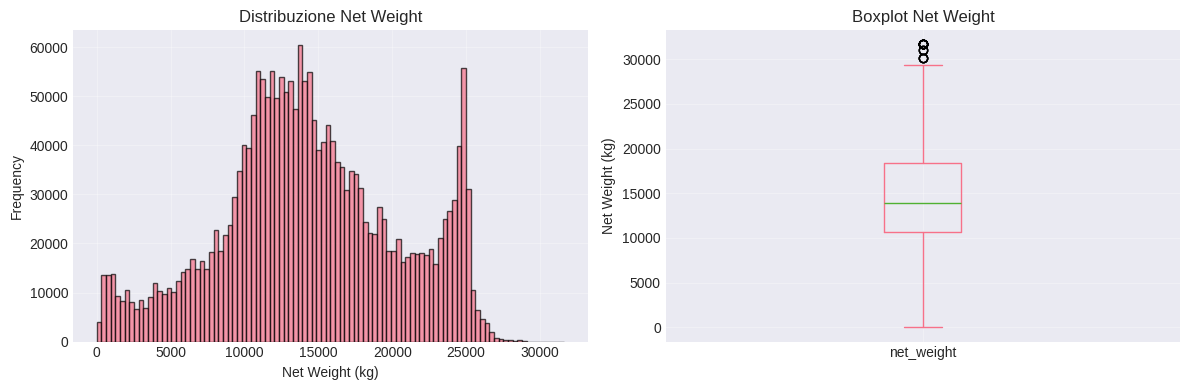


✅ Esplorazione completata!


In [18]:
print("📊 Esplorazione rapida...")

# Info generali
print(f"\nColonne totali: {len(data.columns)}")
print(f"\nPrime 5 colonne:")
print(data.columns[:5].tolist())

# Statistiche target
print(f"\n📊 Statistiche target (net_weight):")
print(data['net_weight'].describe())

# Correlazione con target (top features)
print(f"\n🔗 Top 15 feature correlate con net_weight:")
numeric_cols = data.select_dtypes(include=[np.number]).columns
correlations = data[numeric_cols].corrwith(data['net_weight']).abs().sort_values(ascending=False)
print(correlations.head(15))

# Visualizza distribuzione target
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(data['net_weight'], bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Net Weight (kg)')
plt.ylabel('Frequency')
plt.title('Distribuzione Net Weight')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
data['net_weight'].plot(kind='box')
plt.ylabel('Net Weight (kg)')
plt.title('Boxplot Net Weight')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Esplorazione completata!")